In [ ]:
!pip install facenet-pytorch

In [ ]:
!pip install --upgrade transformers jax jaxlib

In [ ]:
import torch
import torch.nn as nn
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import numpy as np
import os
import pandas as pd
from transformers import ViTModel, ViTConfig
from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import warnings
from collections import defaultdict
from facenet_pytorch import MTCNN


from google.colab import drive
drive.mount('/content/drive')

# ViT model

huggingface pretrained model: https://huggingface.co/dima806/facial_emotions_image_detection

# Dataprocessing

In [ ]:
segment_length = 600
step_size = 400

Fs=10000

mtcnn = MTCNN(image_size=224, margin=0)

model_name = "dima806/facial_emotions_image_detection"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

label_map = {'Happy': 0, 'Sad': 1, 'Neutral': 2, 'Angry': 3}
# label_map = {'Angry': 0}

def normalize_spectrogram(spectrograms):
    means = spectrograms.mean(dim=(-2, -1), keepdim=True)  # Mean over H, W
    stds = spectrograms.std(dim=(-2, -1), keepdim=True)    # Std over H, W

    # Normalize spectrogram
    normalized_spectrograms = (spectrograms - means) / stds

    return normalized_spectrograms

class VideoCSIDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, transform=None, segment_length=None, step_size=None, fs=Fs):
        self.root_dir = root_dir
        self.transform = transform
        self.segment_length = segment_length
        self.step_size = step_size
        self.feature_extractor = feature_extractor
        self.fs = fs

        self.data_segments = []
        for emotion in os.listdir(root_dir):
            print(emotion)
            emotion_dir = os.path.join(root_dir, emotion)
            if os.path.isdir(emotion_dir):
                video_dir = os.path.join(emotion_dir, f'teacher_data_{emotion.lower()}')
                csi_dir = os.path.join(emotion_dir, f'student_data_{emotion.lower()}')

                video_files = sorted(os.listdir(video_dir))
                csi_files = sorted(os.listdir(csi_dir))

                for video_file, csi_file in zip(video_files, csi_files):
                    if video_file.endswith('.mp4') and csi_file.endswith('.csv'):
                        video_path = os.path.join(video_dir, video_file)
                        csi_path = os.path.join(csi_dir, csi_file)
                        print(csi_path)
                        print(video_path)
                        csi_data = pd.read_csv(csi_path, usecols=[25], header=None, skiprows=1)
                        csi_data = csi_data.dropna(subset=[25])
                        csi_data = csi_data[25].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' '))
                        csi_data = np.stack(csi_data.values)
                        csi_segments = self.segment_csi_data(csi_data)

                        num_csi_segments = len(csi_segments)
                        video_segments = self.get_video_segments(video_path, num_csi_segments)

                        for video_segment, csi_segment in zip(video_segments, csi_segments):
                            self.data_segments.append((video_segment, csi_segment, label_map[emotion]))

    def __len__(self):
        return len(self.data_segments)

    def __getitem__(self, idx):
        video_segment, csi_segment, label = self.data_segments[idx]

        # One-hot encoding [1,0,0,0] -> happy, [0,1,0,0] -> sad
        one_hot_label = torch.zeros(len(label_map))
        one_hot_label[label] = 1

        # Process CSI spectrogram
        A = self.process_csi_data([csi_segment])
        spectrogram = self.process_A_to_spectrograms(A)[0]

        normalized_spectrogram = normalize_spectrogram(spectrogram)


        return video_segment, normalized_spectrogram, one_hot_label
        # return video_segment, spectrogram, one_hot_label


    def segment_csi_data(self, csi_data):
        segments = []
        for i in range(0, len(csi_data) - self.segment_length + 1, self.step_size):
            segment = csi_data[i:i + self.segment_length]
            segments.append(segment)
        return segments

    def get_video_segments(self, video_path, num_segments):
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))  # Video frame rate
        segment_length_in_seconds = self.segment_length / self.fs  # CSI segment length in seconds
        step_size_in_seconds = self.step_size / self.fs  # Step size in seconds

        video_segments = []

        for segment_idx in range(num_segments):
            start_second = segment_idx * step_size_in_seconds  # Start time for this segment
            frame = self.get_frame_at_time(cap, start_second, fps)
            if frame is not None:
                video_segments.append(frame)

        cap.release()
        return video_segments

    def get_frame_at_time(self, cap, start_second, fps):
        start_frame = int(start_second * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        ret, frame = cap.read()
        if not ret:
            return None
        frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        to_pil = transforms.ToPILImage()
        # Cropp im
        img_cropped = mtcnn(frame)

        if img_cropped is not None:
            # Cropped image (tensor) -> PIL Image
            img_cropped_pil = (img_cropped + 1) / 2
            img_cropped_pil = to_pil(img_cropped_pil)
            frame = self.feature_extractor(images=img_cropped_pil, return_tensors="pt")["pixel_values"]
        else:
            frame = self.feature_extractor(images=frame, return_tensors="pt")["pixel_values"]

        return frame

    def process_csi_data(self, csi_segments):
        csi_data_list = np.stack(csi_segments, axis=0)
        A = np.sqrt(csi_data_list[:, :, ::2]**2 + csi_data_list[:, :, 1::2]**2)
        A = np.transpose(A, (0, 2, 1))
        # A = torch.FloatTensor(A)
        return A

    def process_A_to_spectrograms(self, A):
        num_segments, num_features = A.shape[0], A.shape[1]
        spectrograms = np.zeros((num_segments, num_features, 224, 224))

        for segment_idx in range(num_segments):
            for feature_idx in range(num_features):
                f, t, Sxx = spectrogram(A[segment_idx, feature_idx, :], nperseg=200)
                Sxx = np.where(Sxx > 0, Sxx, 1e-10)
                Sxx = 10 * np.log10(Sxx)

                Sxx_resized = cv2.resize(Sxx, (224, 224), interpolation=cv2.INTER_LINEAR)

                spectrograms[segment_idx, feature_idx, :, :] = torch.from_numpy(Sxx_resized).float()

        subcarriers_to_remove = list(range(0, 6)) + [32] + list(range(59, 64))
        subcarriers_to_keep = [i for i in range(64) if i not in subcarriers_to_remove]
        spectrograms = spectrograms[:, subcarriers_to_keep, :, :]

        return torch.FloatTensor(spectrograms)

def custom_collate_fn(batch):
    video_segments = [item[0] for item in batch]
    spectrograms = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])

    video_padded = torch.cat(video_segments, dim=0) if video_segments else None

    return video_padded, spectrograms, labels


root_dir = "/content/drive/MyDrive/Quan Emotions"
# root_dir = "/content/drive/MyDrive/zTesting_video_csi"
# root_dir = "/content/drive/MyDrive/Emotions - Anh Huy upload"


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

warnings.filterwarnings("ignore")

dataset = VideoCSIDataset(root_dir=root_dir, feature_extractor=feature_extractor, transform=transform, segment_length=segment_length, step_size=step_size, fs=Fs)

# Train 70%, Val 15%, Test 15%
train_size = int(0.7 * len(dataset))
remaining_size = len(dataset) - train_size
val_size = int(0.5 * remaining_size)
test_size = remaining_size - val_size


train_dataset, remaining_dataset = random_split(dataset, [train_size, remaining_size])
val_dataset, test_dataset = random_split(remaining_dataset, [val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

# Check
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Angry
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry10.csv
/content/drive/MyDrive/Quan Emotions/Angry/teacher_data_angry/angry10.mp4
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry11.csv
/content/drive/MyDrive/Quan Emotions/Angry/teacher_data_angry/angry11.mp4
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry12.csv
/content/drive/MyDrive/Quan Emotions/Angry/teacher_data_angry/angry12.mp4
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry13.csv
/content/drive/MyDrive/Quan Emotions/Angry/teacher_data_angry/angry13.mp4
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry14.csv
/content/drive/MyDrive/Quan Emotions/Angry/teacher_data_angry/angry14.mp4
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry15.csv
/content/drive/MyDrive/Quan Emotions/Angry/teacher_data_angry/angry15.mp4
/content/drive/MyDrive/Quan Emotions/Angry/student_data_angry/angry16.csv
/content/drive/MyDrive/Quan Emot

## Check data

In [ ]:
for batch_idx, (video_frames, csi_data, one_hot_labels) in enumerate(train_dataloader):
    video_frames = video_frames
    print(video_frames)
    print('==================================================')
    csi_data = csi_data
    print(csi_data)


In [ ]:
print("Max value:", csi_data.max().item())
print("Min value:", csi_data.min().item())
print("Max value:", video_frames.max().item())
print("Min value:", video_frames.min().item())

Max value: 7.126697540283203
Min value: -13.396659851074219
Max value: 0.9921568632125854
Min value: -1.0


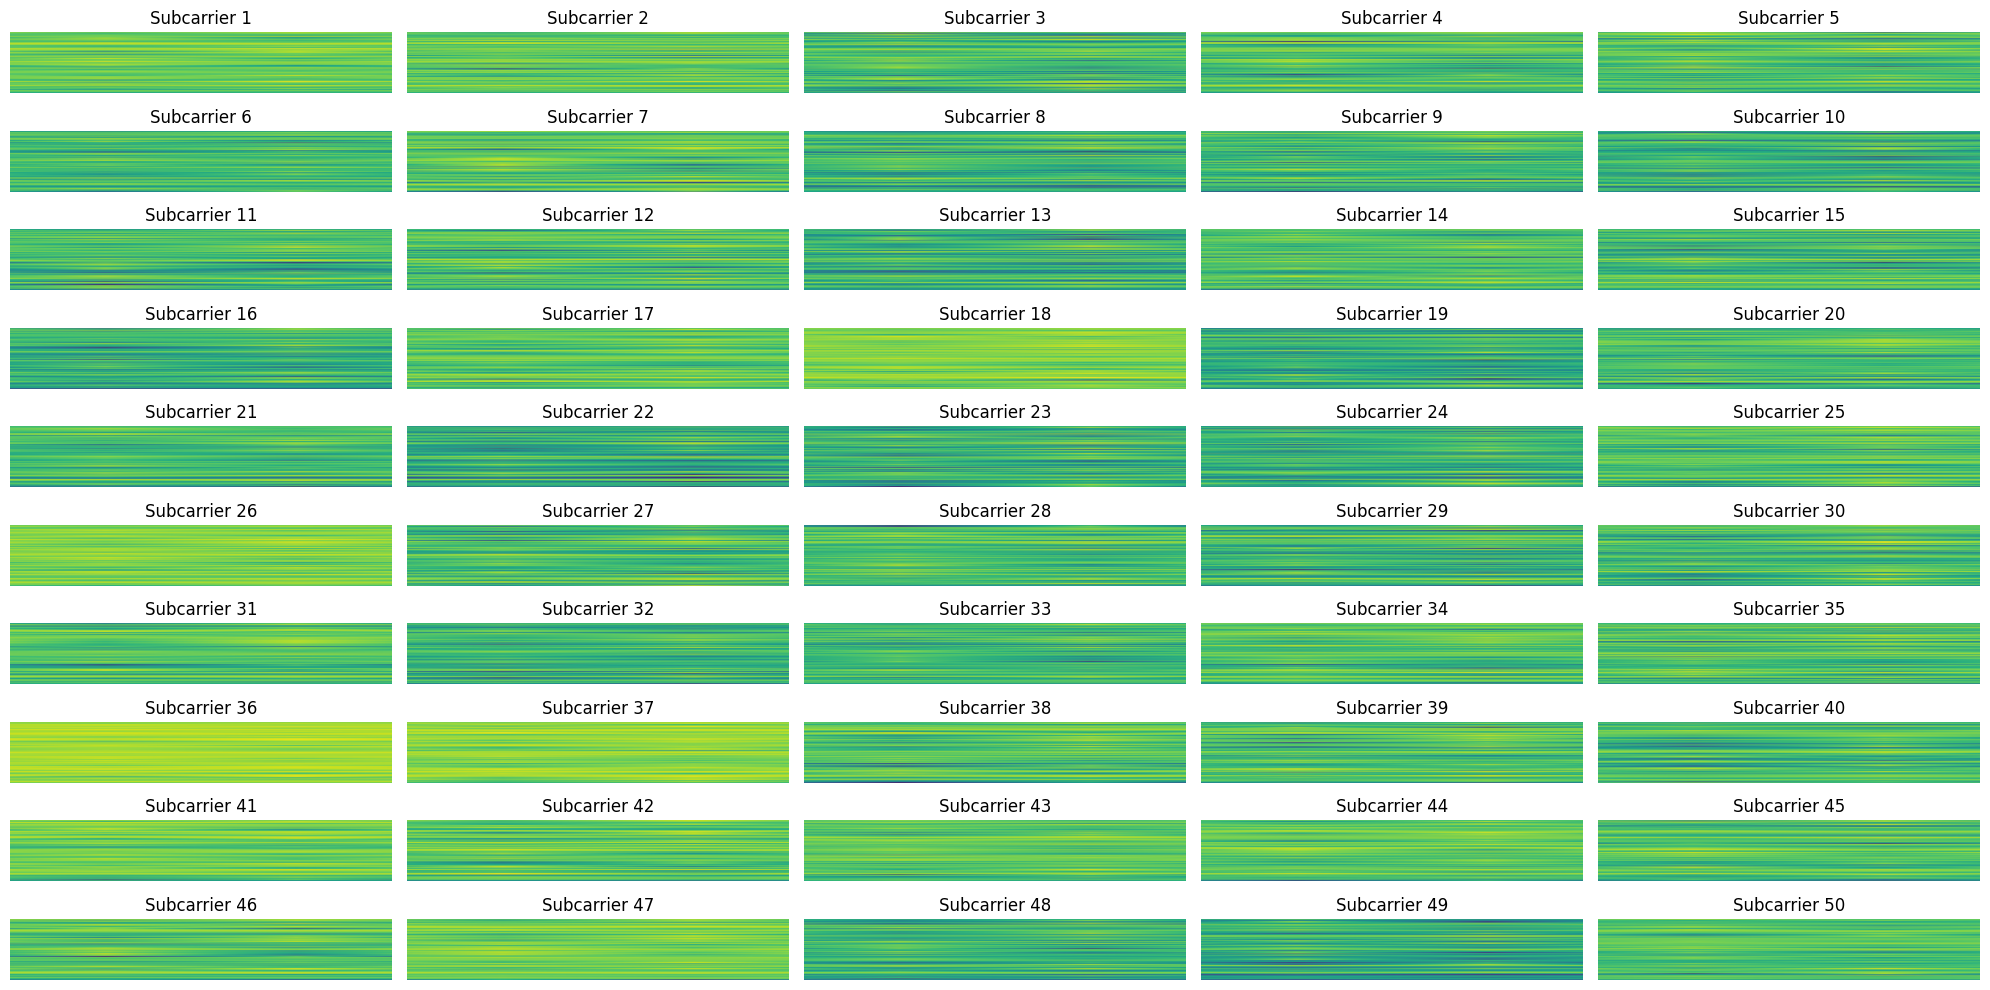

In [ ]:
first_segment = csi_data[0]
# first_segment = normalized_spectrogram[0]


# Plot the 10 subcarriers
fig, axes = plt.subplots(10, 5, figsize=(20, 10)) # 2x5 matrix display

for i, ax in enumerate(axes.flat):
    ax.imshow(first_segment[i], cmap="viridis", aspect="auto")
    ax.set_title(f"Subcarrier {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Output shape
for batch_idx, (video_segments, spectrograms, one_hot_labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    if video_segments is not None:
        print(f"  Video Segments Shape: {video_segments.shape}")
    print(f"  Spectrograms Shape: {spectrograms.shape}")
    print(f"  Labels Shape: {one_hot_labels.shape}")


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)


for batch_idx, (video_segments, spectrograms, labels) in enumerate(train_dataloader):
    print(f"Processing Batch {batch_idx + 1}...")

    if video_segments is not None:
        video_segments = video_segments.to(device)  # Teacher data
    spectrograms = spectrograms.to(device)          # Student data
    labels = labels.to(device)

    # Teacher model prediction
    teacher_outputs = teacher_model(video_segments)
    teacher_logits = teacher_outputs.logits  # Predictions
    teacher_hidden_states = teacher_outputs.hidden_states

    # Student model prediction
    student_logits, student_hidden_states = student_model(spectrograms)

    # Outputs
    print(f"Teacher Logits Shape: {teacher_logits}")
    # print(f"Teacher Hidden States Shape: {[hs.shape for hs in teacher_hidden_states]}")
    print(f"Student Logits Shape: {student_logits.shape}")


## Testing Teacher acc

tensor([[0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])
tensor([[0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0.

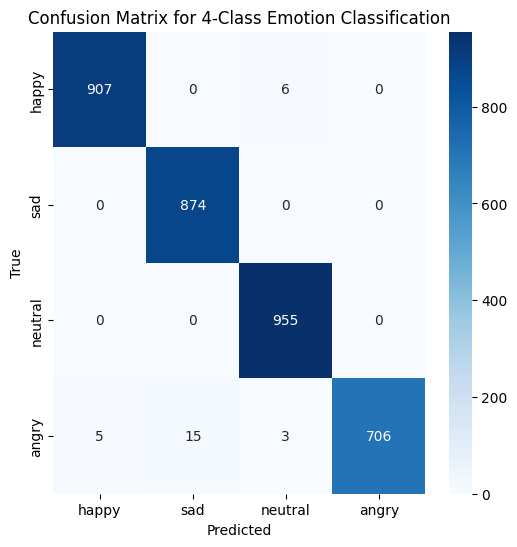

In [ ]:
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# class_names = ["sad", "disgust", "angry", "neutral", "fear", "surprise", "happy"]

# 4 class
class_names = ["happy", "sad", "neutral", "angry"]

emotion_mapping = {
    6: 0,
    0: 1,
    3: 2,
    2: 3
}

all_preds = []
all_labels = []

unwanted_predictions = {"disgust": 0, "fear": 0, "surprise": 0}

for batch_idx, (video_segments, spectrograms, labels) in enumerate(train_dataloader):
    print(labels)
    video_segments = video_segments.cuda()
    labels = labels.cuda()

    # Teacher model prediction
    teacher_outputs = teacher_model(video_segments)
    teacher_logits = teacher_outputs.logits  # [batch_size, 7]

    # softmax to get probabilities
    teacher_probs = F.softmax(teacher_logits, dim=-1)  #[batch_size, 7]

    for i, probs in enumerate(teacher_probs):
        # class has highest probability
        predicted_class = probs.argmax().item()

        # Model's predicted to 4-class label
        if predicted_class in emotion_mapping:
            mapped_pred = emotion_mapping[predicted_class]

            true_class = labels[i].argmax().item()

            if true_class in emotion_mapping.values():
                all_preds.append(mapped_pred)
                all_labels.append(true_class)
        else:
            if predicted_class == 1:
                unwanted_predictions["disgust"] += 1
            elif predicted_class == 4:
                unwanted_predictions["fear"] += 1
            elif predicted_class == 5:
                unwanted_predictions["surprise"] += 1
            # elif predicted_class == 2:
            #     unwanted_predictions["angry"] += 1

# Evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Unwanted predictions
print("\nUnwanted Predictions Count:")
for emotion, count in unwanted_predictions.items():
    print(f"  {emotion}: {count}")

# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 4-Class Emotion Classification')
plt.show()


In [ ]:
# Testing each image

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class_names = ["sad", "disgust", "angry", "neutral", "fear", "surprise", "happy"]

selected_classes = ["happy", "sad", "neutral","angry"]
selected_indices = [class_names.index(emotion) for emotion in selected_classes]

max_images = 30
image_count = 0


for batch_idx, (video_segments, spectrograms, labels) in enumerate(train_dataloader):
    if image_count >= max_images:
        break

    video_segments = video_segments.cuda()

    # Teacher model prediction
    teacher_outputs = teacher_model(video_segments)
    teacher_logits = teacher_outputs.logits  # [batch_size, 7]

    # softmax to get probabilities
    teacher_probs = F.softmax(teacher_logits, dim=-1)  # [batch_size, 7]

    for i in range(video_segments.shape[0]):
        if image_count >= max_images:
            break

        image_count += 1

        # Get predicted class (argmax of probabilities)
        predicted_class = teacher_probs[i].argmax().item()
        predicted_label = class_names[predicted_class]
        predicted_confidence = teacher_probs[i][predicted_class].item() * 100

        # Extract true label (convert one-hot encoding)
        true_class = labels[i].argmax().item()
        true_label = selected_classes[true_class]

        # Convert tensor to image
        frame = video_segments[i].cpu().squeeze(0)
        frame = frame.permute(1, 2, 0).numpy()
        frame = (frame * 255).astype(np.uint8)
        frame = Image.fromarray(frame)

        # Image with prediction
        plt.figure(figsize=(3, 3))
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"{image_count} \nTrue: {true_label} \nPred: {predicted_label} ({predicted_confidence:.1f}%)")
        plt.show()



## Declare Teacher/Student model


https://huggingface.co/docs/transformers/model_doc/vit#transformers.ViTConfig

In [ ]:
from transformers import ViTForImageClassification

# Teacher model
model_name = "dima806/facial_emotions_image_detection"
teacher_model = AutoModelForImageClassification.from_pretrained(model_name).cuda()

for param in teacher_model.parameters():
    param.requires_grad = False


# Student model
class VisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transformer = ViTForImageClassification(config)

    def forward(self, x):
        output = self.transformer(x, output_hidden_states=True)
        return output.logits, output.hidden_states

    def freeze_layers(self, layers_to_freeze):
        if 0 in layers_to_freeze:
            for param in self.transformer.vit.embeddings.parameters():
                param.requires_grad = False

        # Freeze layers
        for i, layer in enumerate(self.transformer.vit.encoder.layer):
            if i in layers_to_freeze:
                for param in layer.parameters():
                    param.requires_grad = False


    def load_teacher_weights(self, teacher_model):
        teacher_vit = teacher_model.vit
        student_vit = self.transformer.vit
        state = {}
        for k, v in teacher_vit.named_parameters():
          if 'embedding' in k:
            continue
          state[k] = v.detach().clone()

        student_vit.load_state_dict(state, strict=False)


# Student model
config = ViTConfig(
    num_channels=52,
    num_labels=4,
    output_hidden_states=True
)

student_model = VisionTransformer(config).cuda()

# Freeze the first 11 layers in the student model
# student_model.freeze_layers(layers_to_freeze=list(range(11)))

# Load teacher weights into the student model (excluding the first layer)
student_model.load_teacher_weights(teacher_model)


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [ ]:
print(teacher_model)

In [ ]:
print(student_model)

# Training Loop

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mse_loss = nn.MSELoss()

# Feature loss
def feature_loss(teacher_features, student_features):
    return mse_loss(teacher_features[-1].detach(), student_features[-1])

optimizer = optim.Adam(filter(lambda p: p.requires_grad, student_model.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,80], gamma=0.1)

# Automatic mixed precision
# scaler = GradScaler()

num_epochs = 20
temperature = 2.0

train_losses = []
val_losses = []


best_vloss = float('inf')
epoch_number = 0

def train_one_epoch(epoch_index):
    student_model.train()
    running_loss = 0.0
    for batch_idx, (video_frames, csi_data, one_hot_labels) in enumerate(train_dataloader):
        video_frames = video_frames.to(device)
        csi_data = csi_data.to(device)
        one_hot_labels = one_hot_labels.to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            # Teacher model inference
            teacher_outputs = teacher_model(video_frames, output_hidden_states=True)
            teacher_features = teacher_outputs.hidden_states

        with autocast():
            # Student model inference
            student_logits, student_features = student_model(csi_data)

            # Cross-entropy loss for logits
            logit_loss = F.cross_entropy(student_logits, one_hot_labels.argmax(dim=1))

            # Feature distillation loss
            feat_loss = feature_loss(teacher_features, student_features)
            feat_loss = feat_loss * 0.001

            # Total loss
            loss = logit_loss + feat_loss

        # Print individual loss each batch
        print(f"Batch {batch_idx + 1}, Logit Loss: {logit_loss.item():.4f}, Feature Loss: {feat_loss.item():.4f}, Total Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    # Average training loss
    avg_train_loss = running_loss / len(train_dataloader)
    return avg_train_loss


# Training loop
for epoch in range(num_epochs):
    print(f'EPOCH {epoch + 1}:')

    student_model.train()
    avg_train_loss = train_one_epoch(epoch)
    train_losses.append(avg_train_loss)

    scheduler.step()

    # Validation
    student_model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for batch_idx, (video_frames, csi_data, one_hot_labels) in enumerate(val_dataloader):
            video_frames = video_frames.to(device)
            csi_data = csi_data.to(device)
            one_hot_labels = one_hot_labels.to(device)

            # Teacher model inference
            teacher_outputs = teacher_model(video_frames, output_hidden_states=True)
            teacher_features = teacher_outputs.hidden_states

            # Student model inference
            student_logits, student_features = student_model(csi_data)

            # Cross-entropy loss for logits
            logit_loss = F.cross_entropy(student_logits, one_hot_labels.argmax(dim=1))

            # Feature distillation loss
            feat_loss = feature_loss(teacher_features, student_features)
            feat_loss = feat_loss * 0.001

            # Total loss
            val_loss = logit_loss + feat_loss
            running_vloss += val_loss.item()

    avg_vloss = running_vloss / (batch_idx + 1)
    val_losses.append(avg_vloss)

    print(f'LOSS train {avg_train_loss:.4f} valid {avg_vloss:.4f}')

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'zmodel_epoch_{epoch + 1}'
        torch.save(student_model.state_dict(), model_path)
        print(f"Saved new best model at epoch {epoch + 1} with validation loss {best_vloss:.4f}")

    epoch_number += 1


EPOCH 1:
Batch 1, Logit Loss: 1.3989, Feature Loss: 0.3245, Total Loss: 1.7234
Batch 2, Logit Loss: 1.4988, Feature Loss: 0.4798, Total Loss: 1.9786
Batch 3, Logit Loss: 1.3315, Feature Loss: 0.4358, Total Loss: 1.7673
Batch 4, Logit Loss: 1.6072, Feature Loss: 0.5335, Total Loss: 2.1407
Batch 5, Logit Loss: 1.3557, Feature Loss: 0.6478, Total Loss: 2.0035
Batch 6, Logit Loss: 1.3516, Feature Loss: 0.5625, Total Loss: 1.9140
Batch 7, Logit Loss: 1.3435, Feature Loss: 0.5080, Total Loss: 1.8515
Batch 8, Logit Loss: 1.6746, Feature Loss: 0.4501, Total Loss: 2.1247
Batch 9, Logit Loss: 1.2878, Feature Loss: 0.4901, Total Loss: 1.7778
Batch 10, Logit Loss: 1.4122, Feature Loss: 0.4848, Total Loss: 1.8970
Batch 11, Logit Loss: 1.2800, Feature Loss: 0.4898, Total Loss: 1.7698
Batch 12, Logit Loss: 1.4017, Feature Loss: 0.4799, Total Loss: 1.8815
Batch 13, Logit Loss: 1.3021, Feature Loss: 0.4930, Total Loss: 1.7951
Batch 14, Logit Loss: 1.3220, Feature Loss: 0.4969, Total Loss: 1.8190
Batch 

KeyboardInterrupt: 

## Evaluation metrics (for student model)

Average Precision: 0.6987
Average Recall: 0.6423
Average F1-Score: 0.6370


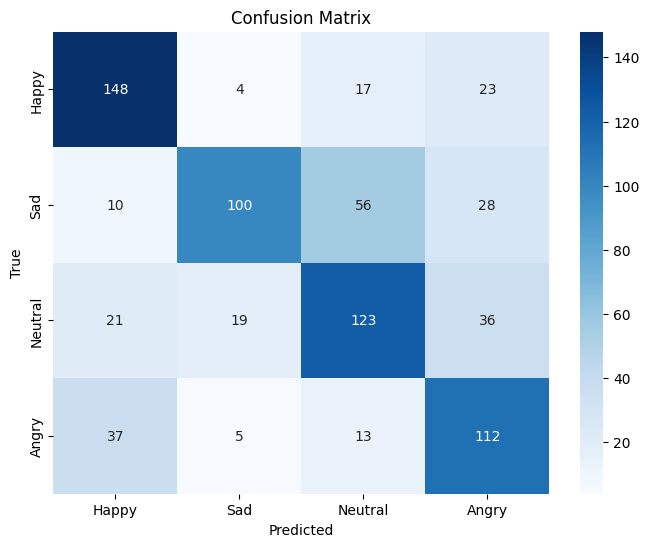

In [ ]:
def compute_metrics(predictions, labels):
    # Convert predictions to class indices
    _, pred_classes = torch.max(predictions, dim=1)
    _, true_classes = torch.max(labels, dim=1)

    # Precision, Recall, F1-Score (use average='weighted' for multi-class/multi-label tasks)
    precision = precision_score(true_classes.cpu(), pred_classes.cpu(), average='weighted')
    recall = recall_score(true_classes.cpu(), pred_classes.cpu(), average='weighted')
    f1 = f1_score(true_classes.cpu(), pred_classes.cpu(), average='weighted')

    return precision, recall, f1

def plot_confusion_matrix(predictions, labels, class_names):
    # Convert predictions to class indices
    _, pred_classes = torch.max(predictions, dim=1)
    _, true_classes = torch.max(labels, dim=1)

    cm = confusion_matrix(true_classes.cpu(), pred_classes.cpu())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_student_model(model, test_dataloader, class_names):
    model.eval()
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (video_frames, csi_data, one_hot_labels) in enumerate(test_dataloader):
            # video_frames = video_frames.to(device)
            csi_data = csi_data.to(device)
            one_hot_labels = one_hot_labels.to(device)

            logits, _ = model(csi_data)

            # Compute precision, recall, f1
            precision, recall, f1 = compute_metrics(logits, one_hot_labels)
            total_precision += precision
            total_recall += recall
            total_f1 += f1

            # Collect all predictions and labels for confusion matrix
            all_predictions.append(logits)
            all_labels.append(one_hot_labels)

    avg_precision = total_precision / (batch_idx + 1)
    avg_recall = total_recall / (batch_idx + 1)
    avg_f1 = total_f1 / (batch_idx + 1)

    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1-Score: {avg_f1:.4f}")

    # Concatenate all predictions and labels
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Confusion matrix
    plot_confusion_matrix(all_predictions, all_labels, class_names)

    return avg_precision, avg_recall, avg_f1


student_modelz = VisionTransformer(config).cuda()
student_modelz.load_state_dict(torch.load('/content/zmodel_epoch_8'))
student_modelz.eval()


class_names = ['Happy', 'Sad', 'Neutral', 'Angry']
avg_precision, avg_recall, avg_f1 = evaluate_student_model(student_modelz, val_dataloader, class_names)


# Testing Student model on specific file

In [ ]:
from collections import Counter

# Load student model
student_model = VisionTransformer(config).cuda()
student_model.load_state_dict(torch.load('/content/zmodel_epoch_8'))
student_model.eval()

Fs = 10000  # Sampling rate
segment_length = 600
step_size = 400

class_names = ['Happy', 'Sad', 'Neutral', 'Angry']
label_map = {'Happy': 0, 'Sad': 1, 'Neutral': 2, 'Angry': 3}

def normalize_spectrogram(spectrogram):
    means = spectrogram.mean(dim=(-2, -1), keepdim=True)
    stds = spectrogram.std(dim=(-2, -1), keepdim=True)
    return (spectrogram - means) / stds

def segment_csi_data(csi_data):
    segments = []
    for i in range(0, len(csi_data) - segment_length + 1, step_size):
        segments.append(csi_data[i:i + segment_length])
    return segments

def process_csi_data(csi_segments):
    csi_data_list = np.stack(csi_segments, axis=0)
    A = np.sqrt(csi_data_list[:, :, ::2]**2 + csi_data_list[:, :, 1::2]**2)
    A = np.transpose(A, (0, 2, 1))
    return torch.FloatTensor(A)

def process_A_to_spectrograms(A):
    num_segments, num_features = A.shape[0], A.shape[1]
    spectrograms = np.zeros((num_segments, num_features, 224, 224))

    for segment_idx in range(num_segments):
        for feature_idx in range(num_features):
            f, t, Sxx = spectrogram(A[segment_idx, feature_idx, :], nperseg=200)
            Sxx = np.where(Sxx > 0, Sxx, 1e-10)
            Sxx = 10 * np.log10(Sxx)

            Sxx_resized = cv2.resize(Sxx, (224, 224), interpolation=cv2.INTER_LINEAR)

            spectrograms[segment_idx, feature_idx, :, :] = torch.from_numpy(Sxx_resized).float()

    subcarriers_to_remove = list(range(0, 6)) + [32] + list(range(59, 64))
    subcarriers_to_keep = [i for i in range(64) if i not in subcarriers_to_remove]
    spectrograms = spectrograms[:, subcarriers_to_keep, :, :]

    return torch.FloatTensor(spectrograms)

def evaluate_single_csi_file(csi_file):
    # Load CSI data
    csi_data = pd.read_csv(csi_file, usecols=[25], header=None, skiprows=1)
    csi_data = csi_data.dropna(subset=[25])
    csi_data = csi_data[25].apply(lambda x: np.fromstring(x[1:-1], dtype=float, sep=' '))
    csi_data = np.stack(csi_data.values)

    # Segment CSI data
    csi_segments = segment_csi_data(csi_data)

    # Convert to spectrogram
    A = process_csi_data(csi_segments)
    spectrograms = process_A_to_spectrograms(A)
    spectrograms = normalize_spectrogram(spectrograms)

    spectrograms = spectrograms.cuda()

    # Make predictions
    with torch.no_grad():
        logits, _ = student_model(spectrograms)
        _, predictions = torch.max(logits, dim=1)

    predicted_labels = [class_names[pred.item()] for pred in predictions]

    # Count the number of each emotion
    emotion_counts = Counter(predicted_labels)

    return predicted_labels, emotion_counts

# Example usage
csi_file_path = "/content/drive/MyDrive/neutraltest.csv"
predicted_labels, emotion_counts = evaluate_single_csi_file(csi_file_path)
print("Predicted emotions:", predicted_labels)
print("Emotion counts:", emotion_counts)

Predicted emotions: ['Angry', 'Happy', 'Happy', 'Happy', 'Angry', 'Angry', 'Angry', 'Angry', 'Neutral', 'Happy', 'Angry', 'Neutral', 'Neutral', 'Neutral', 'Angry']
Emotion counts: Counter({'Angry': 7, 'Happy': 4, 'Neutral': 4})


In [ ]:
# neutraltest.csv
Predicted emotions: ['Angry', 'Happy', 'Happy', 'Happy', 'Angry', 'Angry', 'Angry', 'Angry', 'Neutral', 'Happy', 'Angry', 'Neutral', 'Neutral', 'Neutral', 'Angry']
Emotion counts: Counter({'Angry': 7, 'Happy': 4, 'Neutral': 4})

In [ ]:
# happytest.csv
Predicted emotions: ['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']
Emotion counts: Counter({'Happy': 15})

In [ ]:
Predicted emotions: ['Sad', 'Sad', 'Sad', 'Neutral', 'Sad', 'Sad', 'Angry', 'Sad', 'Sad', 'Angry', 'Sad', 'Sad', 'Neutral', 'Neutral', 'Angry', 'Sad']
Emotion counts: Counter({'Sad': 10, 'Neutral': 3, 'Angry': 3})

In [ ]:
# sad1.csv
